In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
mailout_train.shape

(42962, 367)

In [5]:
mailout_test.shape

(42833, 366)

## 1- Clean the data

In [6]:
mailout_train_raw = mailout_train.drop(labels='RESPONSE',axis=1)

In [7]:
mailout_train_raw = mailout_train_raw.sort_values('LNR')
mailout_test_raw = mailout_test.sort_values('LNR')

In [8]:
# Set LNR columns as index
mailout_train_raw = mailout_train_raw.set_index('LNR')
mailout_test_raw = mailout_test_raw.set_index('LNR')

In [9]:
mailout_train_raw['D19_LETZTER_KAUF_BRANCHE'] = mailout_train_raw['D19_LETZTER_KAUF_BRANCHE'].fillna('nan')
mailout_test_raw['D19_LETZTER_KAUF_BRANCHE'] = mailout_test_raw['D19_LETZTER_KAUF_BRANCHE'].fillna('nan')

In [10]:
kf = {'D19_BANKEN_DIREKT':0,
 'D19_BANKEN_GROSS':1,
 'D19_BANKEN_LOKAL':2,
 'D19_BANKEN_REST':3,
 'D19_BEKLEIDUNG_GEH':4,
 'D19_BEKLEIDUNG_REST':5,
 'D19_BILDUNG':6,
 'D19_BIO_OEKO':7,
 'D19_BUCH_CD':8,
 'D19_DIGIT_SERV':9,
 'D19_DROGERIEARTIKEL':10,
 'D19_ENERGIE':11,
 'D19_FREIZEIT':12,
 'D19_GARTEN':13,
 'D19_HANDWERK':14,
 'D19_HAUS_DEKO':15,
 'D19_KINDERARTIKEL':16,
 'D19_KOSMETIK':17,
 'D19_LEBENSMITTEL':18,
 'D19_LOTTO':19,
 'D19_NAHRUNGSERGAENZUNG':20,
 'D19_RATGEBER':21,
 'D19_REISEN':22,
 'D19_SAMMELARTIKEL':23,
 'D19_SCHUHE':24,
 'D19_SONSTIGE':25,
 'D19_TECHNIK':26,
 'D19_TELKO_MOBILE':27,
 'D19_TELKO_REST':28,
 'D19_TIERARTIKEL':29,
 'D19_UNBEKANNT':30,
 'D19_VERSAND_REST':31,
 'D19_VERSICHERUNGEN':32,
 'D19_VOLLSORTIMENT':33,
 'D19_WEIN_FEINKOST':34,
'nan':-1}

##### VII. Creating CAMEO_DEU_2015 dictionary:

In [11]:
print ('The CAMEO_DEU_2015  of customers dataframe are as follows:\n')
set(mailout_train_raw['CAMEO_DEU_2015'])

The CAMEO_DEU_2015  of customers dataframe are as follows:



{'1A',
 '1B',
 '1C',
 '1D',
 '1E',
 '2A',
 '2B',
 '2C',
 '2D',
 '3A',
 '3B',
 '3C',
 '3D',
 '4A',
 '4B',
 '4C',
 '4D',
 '4E',
 '5A',
 '5B',
 '5C',
 '5D',
 '5E',
 '5F',
 '6A',
 '6B',
 '6C',
 '6D',
 '6E',
 '6F',
 '7A',
 '7B',
 '7C',
 '7D',
 '7E',
 '8A',
 '8B',
 '8C',
 '8D',
 '9A',
 '9B',
 '9C',
 '9D',
 '9E',
 'XX',
 nan}

In [12]:
#Replacing NaNs with string NaNs
mailout_train_raw['CAMEO_DEU_2015'] = mailout_train_raw['CAMEO_DEU_2015'].fillna('nan')
mailout_test_raw['CAMEO_DEU_2015'] = mailout_test_raw['CAMEO_DEU_2015'].fillna('nan')

In [13]:
# Defining a dictionary to convert string values to integer
cam = {'1A':1,
 '1B':2,
 '1C':3,
 '1D':4,
 '1E':5,
 '2A':6,
 '2B':7,
 '2C':8,
 '2D':9,
 '3A':10,
 '3B':11,
 '3C':12,
 '3D':13,
 '4A':14,
 '4B':15,
 '4C':16,
 '4D':17,
 '4E':18,
 '5A':19,
 '5B':20,
 '5C':21,
 '5D':22,
 '5E':23,
 '5F':24,
 '6A':25,
 '6B':26,
 '6C':27,
 '6D':28,
 '6E':29,
 '6F':30,
 '7A':31,
 '7B':32,
 '7C':33,
 '7D':34,
 '7E':35,
 '8A':36,
 '8B':37,
 '8C':38,
 '8D':39,
 '9A':40,
 '9B':41,
 '9C':42,
 '9D':43,
 '9E':44,
 'XX':45,
 'nan':-1}

##### VIII. Applying lambda function to each column

In [14]:
def convert_non_values(df,dict,feature):

    df[feature] = df[feature].apply(lambda x: dict[x])

In [15]:
# Converting features discussed previously
convert_non_values(mailout_test_raw,kf,'D19_LETZTER_KAUF_BRANCHE')
convert_non_values(mailout_test_raw,cam,'CAMEO_DEU_2015')
convert_non_values(mailout_train_raw,kf,'D19_LETZTER_KAUF_BRANCHE')
convert_non_values(mailout_train_raw,cam,'CAMEO_DEU_2015')

In [16]:
# Identifying non values columns
mailout_train_raw_subset = mailout_train_raw.select_dtypes(exclude=[np.float, np.int])
mailout_test_raw_subset = mailout_test_raw.select_dtypes(exclude=[np.float, np.int])

In [17]:
mailout_train_raw.to_pickle("mailout_train_raw_subset.pkl")
mailout_test_raw.to_pickle("mailout_test_raw_subset.pkl")

In [18]:
# Dropping columns
clean_mailout_train_raw = mailout_train_raw.drop(['OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)
clean_mailout_test_raw = mailout_test_raw.drop(['OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)

##### II. Converting remaining non values data to numeric values otherwise replace with NaN

In [19]:
clean_mailout_train_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = clean_mailout_train_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric, errors='coerce')
clean_mailout_test_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = clean_mailout_test_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric, errors='coerce')

##### III. Replacing unknown (-1) and none (0) values with NaN

In [20]:
clean_mailout_train_raw.replace([0,-1], np.nan, inplace=True)
clean_mailout_test_raw.replace([0,-1], np.nan, inplace=True)

##### IV. Analyzing NaN values in dataset

As we have noticed during the data exploration many of dataset columns contain more than 30% of NaN values. First we go to vizualize the percentage of NaN data in each feature using [Seaborn barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) module. Then according to our analyze we will decide on how many columns to drop.

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,42922,0.999069
ALTER_KIND4,42921,0.999046
D19_VERSI_ONLINE_QUOTE_12,42902,0.998603
ALTER_KIND3,42788,0.995950
TITEL_KZ,42749,0.995042


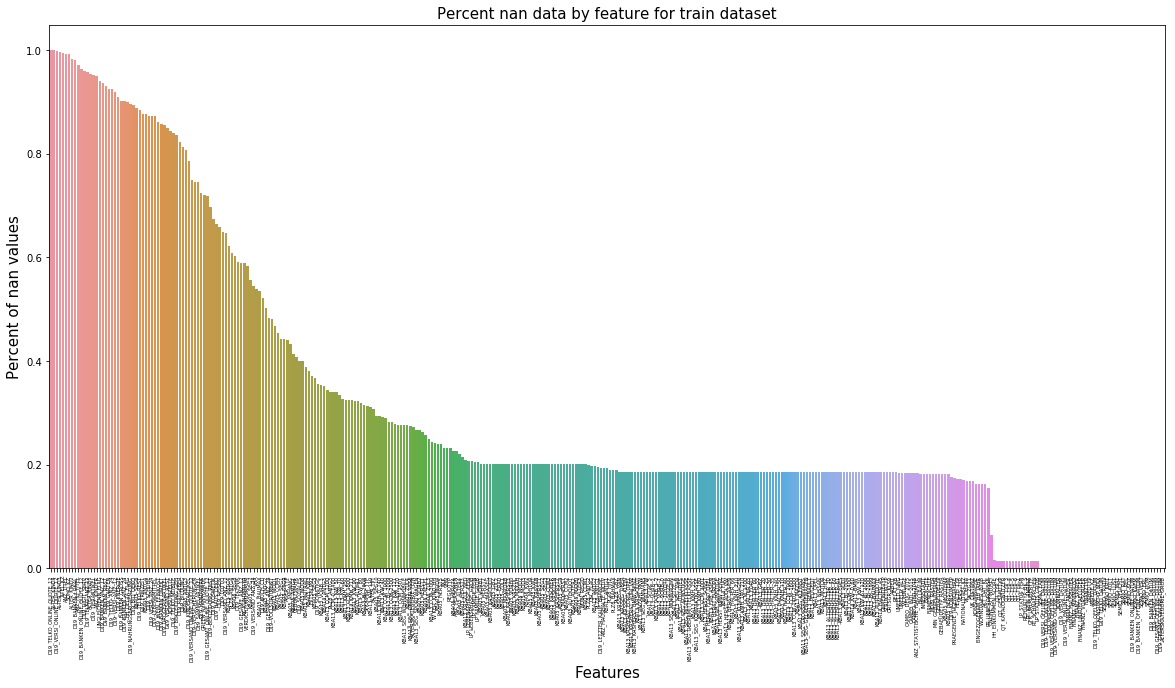

In [21]:
total = clean_mailout_train_raw.isna().sum().sort_values(ascending=False)
percent = (clean_mailout_train_raw.isna().sum()/clean_mailout_train_raw.isna().count()).sort_values(ascending=False)
nan_data_mailout_train_raw = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(20, 10))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(5)

    plt.xticks(rotation='90')
sns.barplot(x=nan_data_mailout_train_raw.index, y=nan_data_mailout_train_raw['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of nan values', fontsize=15)
plt.title('Percent nan data by feature for train dataset', fontsize=15)

nan_data_mailout_train_raw.head()

##### V. Dropping columns with more than 10% of NaN values

We have decided to drop columns with more than 20% NaN values in customers dataset and the same operation is applied to azidas dataset in order to get the same output (the same shape for both datasets). First we create a list of features having more han 20% NaNs and then these columns are dropped.

In [22]:
# Features that we keep for Train an Test dataframes
clean_mailout_train_raw_dropna = clean_mailout_train_raw[['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
        'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ',
        'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP', 'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB']]

In [23]:
clean_mailout_test_raw_dropna = clean_mailout_test_raw[['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
        'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ',
        'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP', 'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB']]

In [24]:
# Remaining features and length 
clean_mailout_train_raw_dropna.columns, len(clean_mailout_train_raw_dropna.columns)

(Index(['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SE

##### VII. Replacing remaining NaNs with -1 value

In [25]:
clean_mailout_train_raw_fillna = clean_mailout_train_raw_dropna.fillna(-1)
clean_mailout_test_raw_fillna = clean_mailout_test_raw_dropna.fillna(-1)

##### VIII. Checking data type and cleaned values

In [26]:
# Counting NaN values for each column
clean_mailout_train_raw_fillna.apply(lambda x:x.isna().sum())
clean_mailout_test_raw_fillna.apply(lambda x:x.isna().sum())

CJT_GESAMTTYP                0
CJT_KATALOGNUTZER            0
CJT_TYP_1                    0
CJT_TYP_2                    0
CJT_TYP_3                    0
CJT_TYP_4                    0
CJT_TYP_5                    0
CJT_TYP_6                    0
D19_BANKEN_DATUM             0
D19_BANKEN_OFFLINE_DATUM     0
D19_BANKEN_ONLINE_DATUM      0
D19_GESAMT_DATUM             0
D19_GESAMT_OFFLINE_DATUM     0
D19_GESAMT_ONLINE_DATUM      0
D19_KONSUMTYP_MAX            0
D19_TELKO_DATUM              0
D19_TELKO_OFFLINE_DATUM      0
D19_TELKO_ONLINE_DATUM       0
D19_VERSAND_DATUM            0
D19_VERSAND_OFFLINE_DATUM    0
D19_VERSAND_ONLINE_DATUM     0
D19_VERSI_DATUM              0
D19_VERSI_OFFLINE_DATUM      0
D19_VERSI_ONLINE_DATUM       0
FINANZ_ANLEGER               0
FINANZ_HAUSBAUER             0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_UNAUFFAELLIGER        0
FINANZ_VORSORGER             0
FINANZTYP                    0
GFK_URLAUBERTYP              0
HH_EINKO

In [27]:
# Data types
set(clean_mailout_train_raw_fillna.dtypes)
set(clean_mailout_test_raw_fillna.dtypes)

{dtype('int64'), dtype('float64')}

##### IX. Normalizing the data

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. In our dataset, normalization is required because features have different ranges. We transforms features by scaling each feature between zero and one using [MinMaxScler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from Scikitleran module
We create an estimator which scales and translates each feature individually such that it is between zero and one.

In [28]:
# Creating scaled customers dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

mailout_train_scaled = pd.DataFrame(scaler.fit_transform(clean_mailout_train_raw_fillna.astype(float)))
mailout_train_scaled.index = clean_mailout_train_raw_fillna.index
mailout_train_scaled.columns = clean_mailout_train_raw_fillna.columns

mailout_test_scaled = pd.DataFrame(scaler.fit_transform(clean_mailout_test_raw_fillna.astype(float)))
mailout_test_scaled.index = clean_mailout_test_raw_fillna.index
mailout_test_scaled.columns = clean_mailout_test_raw_fillna.columns

### Save cleaned data as pickle file

In [29]:
mailout_train_scaled.to_pickle("cleaned_mailout_train.pkl")
mailout_train_scaled.to_pickle("cleaned_mailout_test.pkl")

## 2- Dimensionality Reduction with PCA

In [30]:
# Loading pca_azidas model
filename = 'pca_model.sav'
pca_azdias = pickle.load(open(filename, 'rb'))

In [31]:
reduced_mailout_train = pca_azdias.transform(mailout_train_scaled)
reduced_mailout_test = pca_azdias.transform(mailout_test_scaled)

In [32]:
min_features = mailout_train_scaled.shape[1]-1
reduced_mailout_train = pd.DataFrame(data=reduced_mailout_train, \
                                 columns = ['c_{}'.format(i) for i in range(min_features)], \
                                 index = mailout_train_scaled.index)

min_features = mailout_test_scaled.shape[1]-1
reduced_mailout_test = pd.DataFrame(data=reduced_mailout_test, \
                                 columns = ['c_{}'.format(i) for i in range(min_features)], \
                                 index = mailout_test_scaled.index)

In [33]:
reduced_mailout_train.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54,c_55
LNR,,,,,,,,,,,,,,,,,,,,,
1,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
5,0.602320,-0.515073,-0.789517,-1.173841,0.843082,0.350187,-0.202789,-0.055925,0.205694,-0.184959,...,-0.006888,0.014425,-0.187576,-0.027908,-0.000760,0.001553,0.002093,0.000328,-0.000828,0.027867
9,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
10,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
11,-0.455526,-0.452935,1.060285,-0.600518,0.012174,-0.524961,0.022830,0.061882,-0.066046,-0.010786,...,0.053181,-0.282793,0.028975,-0.034087,-0.374502,0.057363,0.014396,0.002156,0.009773,-0.024367


In [34]:
# The good top_n for azdias dataframe
top_n=16
print ('We retain {} components and capture {}% explained variance for train dataframe'\
       .format(top_n,(pca_azdias.explained_variance_ratio_[:top_n].sum()*100).round(2)))
print ('We retain {} components and capture {}% explained variance for test dataframe'\
       .format(top_n,(pca_azdias.explained_variance_ratio_[:top_n].sum()*100).round(2)))

We retain 16 components and capture 84.21% explained variance for train dataframe
We retain 16 components and capture 84.21% explained variance for test dataframe


In [35]:
columns = ['c_{}'.format(i) for i in range(top_n)]
reduced_mailout_train = reduced_mailout_train[columns]
reduced_mailout_test = reduced_mailout_test[columns]

In [36]:
reduced_mailout_train.shape

(42962, 16)

In [37]:
reduced_mailout_train.to_pickle("reduced_mailout_train.pkl")
reduced_mailout_test.to_pickle("reduced_mailout_test.pkl")

## 3- Linear Learner (Sagemaker)

***IMPORTANT: This section is executed on Amazon SageMaker platform notebook. LinearLearner is a buitlin algorithm and we are only able to train and deploy this algorithm on Amazon SageMaker. You should note that the following files are uploaded to S3 bucket and read using AWS imported packages:***

- `reduced_mailout_train.csv (reduced train data)`
- `reduced_mailout_test.csv (reduced test data to submit to Kaggle)`
- `train_response.csv (train labels)`

The following code is implemented in Amazon SageMaker platform.  Linear Learner is a built-in algorithm provided by Amazon SageMaker used for solving either classification or regression problems. in this project we will  use this binary classifier on this platform where it is trained, deployed and evluated on train MAIL_OUT dataset. 
The Amazon SageMaker linear learner algorithm provides a solution for binary classification problems. With the Amazon SageMaker algorithm, we can simultaneously explore different training objectives and choose the best solution from a validation set. We can also explore a large number of parameters and choose the best. The best model optimizes either of the following:

- Continuous objectives, such as mean square error, cross entropy loss, absolute error.
- Discrete objectives suited for classification, such as F1 measure, precision, recall, or accuracy.

##### I. Load preprocessed Data from S3

In this section, we have created four files in S3: a `reduced_mailout_train.csv` and `reduced_mailout_test.csv` file with the reduced features and `train_response.csv`, `test_response.csv` file with the labels

>The below cells load in some AWS SageMaker libraries and are created in publicly availabe **sagemaker-us-east-2-635229580099** bucket.

In [2]:
import pandas as pd
import boto3
import sagemaker
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
bucket

'sagemaker-us-east-2-635229580099'

In [5]:

data_key_X = 'reduced_mailout_train.csv'
data_key_y = 'train_response.csv'

data_location_X = 's3://{}/{}'.format(bucket, data_key_X)
data_location_y = 's3://{}/{}'.format(bucket, data_key_y)


X = pd.read_csv(data_location_X)
y = pd.read_csv(data_location_y)

###### II. Splitting the data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Here, the Dataset is broken into two parts in a ratio of 75:25. It means 75% data will be used for model training and 33% for model testing. Now, we fit our model on the train set using fit() and perform prediction on the test set using predict().

##### III. Imbalanced training data

At the exploration section, we saw that only about 1% of the data was labeled to be in mail_order list. So, even if a model labels all of our data as valid, it will still have a high accuracy. This may affect our principal goal which is to predict and identify customers that are likely to be in mail-order marketing campaign. The important point here is that we want to capture almost all customers classed to be in the mail list. That means we want to have high True Positive and low False Negative as possible which means high `Recall`. To compensate the existing imbalance we will set `positive_example_weight_mult` parameter to `balanced`. Then our target is to get the highest recall as possible so we set the `binary_classifier_model_selection_criteria` parameter to `precision_at_target_recall`.



In [8]:
# Label distribution
labels = pd.Series(y_test.values.ravel())
labels.value_counts()

0    10601
1      140
dtype: int64

In [9]:
# Ratio Calculation
positive_response_ratio = labels.value_counts()[1]/labels.value_counts()[0]
print ('The positive response to mail campaign ratio is {:.2f}'.format(positive_response_ratio))

The positive response to mail campaign ratio is 0.01


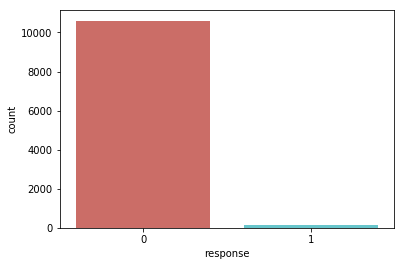

In [10]:
# Count plot of labels
sns.countplot(data=labels, x=labels.index, palette='hls')
plt.xlabel('response')
plt.show()

##### IV. Create a LinearLearner Estimator

In [21]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'capstone_out'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                        train_instance_count=1, 
                        train_instance_type='ml.c4.xlarge',
                        predictor_type='binary_classifier',
                        output_path=output_path,
                        sagemaker_session=sagemaker_session,
                        epochs=20,
                        binary_classifier_model_selection_criteria='precision_at_target_recall',
                        target_precision=0.8,
                        positive_example_weight_mult='balanced')

##### V. Convert data into a RecordSet format

In [12]:
# convert features/labels to numpy
train_x_np = X_train.values.astype('float32')
train_y_np = y_train.values.squeeze().astype('float32')
test_x_np = X_test.values.astype('float32')
test_y_np = y_test.values.squeeze().astype('float32')


# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

In [13]:
formatted_train_data

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-2-635229580099/sagemaker-record-sets/LinearLearner-2019-08-11-14-06-39-758/.amazon.manifest', 'feature_dim': 16, 'num_records': 32221, 's3_data_type': 'ManifestFile', 'channel': 'train'})

In [14]:
train_x_np[10],train_y_np[10]

(array([-1.3715047 ,  0.9703056 , -0.11625351, -0.09607597,  0.15708666,
        -0.8512137 , -0.06170477,  0.21805191, -0.12487005, -0.00304065,
        -0.24735336, -0.13283318, -0.01412   ,  0.14167145,  0.21693088,
        -0.00263326], dtype=float32), 0.0)

##### VI. Train  and deploy the Estimator

In [15]:
linear.fit(formatted_train_data)

2019-08-11 14:06:41 Starting - Starting the training job...
2019-08-11 14:06:46 Starting - Launching requested ML instances......
2019-08-11 14:07:49 Starting - Preparing the instances for training......
2019-08-11 14:09:00 Downloading - Downloading input data...
2019-08-11 14:09:41 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[08/11/2019 14:09:56 INFO 140680134403904] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall'


2019-08-11 14:10:10 Uploading - Uploading generated training model[2019-08-11 14:09:59.140] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 981, "num_examples": 33, "num_bytes": 3479868}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 1.3504363155364991, "sum": 1.3504363155364991, "min": 1.3504363155364991}}, "EndTime": 1565532599.140477, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1565532599.140386}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 1.3516312503814698, "sum": 1.3516312503814698, "min": 1.3516312503814698}}, "EndTime": 1565532599.140568, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1565532599.140547}

#metrics {"Metrics": {"train_binary_classi


2019-08-11 14:10:16 Completed - Training job completed
Billable seconds: 77


In [16]:
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------------------------------------------------------------------------------------------------------------------!

##### VII. Evaluating Model

In this part we will create a function capable of evaluating out predictor created in last section. This function will first calculate tp, fp, tn and fn. Then using these values `Accuracy`, `Precision`, `Recall` and `f1` are calculated.

In [17]:
# Converting test data to numpy array
test_x_np = X_test.values.astype('float32')
test_y_np = y_test.values.squeeze().astype('float32')
test_x_np[0]

array([-1.1721809 ,  0.93151766,  0.25406912, -0.02219727,  0.33041495,
       -0.39785215,  0.43600228,  0.35751784, -0.2445548 , -0.1657527 ,
        0.11939578, -0.21016099, -0.2651045 ,  0.27220383,  0.35134873,
        0.00938801], dtype=float32)

In [18]:
# Comparing labeled value with predicted value
result = linear_predictor.predict(test_x_np[12])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.628894567489624
    }
  }
}
]


In [19]:
# function to evaluate the endpoint on test data
# Returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in test_features]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1_score = 2*(recall * precision)/(recall + precision)
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('f1_score:', f1_score))
        
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy, 'f1_score':f1_score}

In [20]:
metrics = evaluate(linear_predictor, test_x_np, test_y_np, True)

prediction (col)   0.0   1.0
actual (row)                
0.0               4247  6354
1.0                 23   117

Recall:     0.836
Precision:  0.018
Accuracy:   0.406
f1_score:   0.035



##### VIII. Clean up Resources


After we're done evaluating the model, **delete the model endpoint**. We can do this with a call to `.delete_endpoint()`. In the same way we delete all resources from `S3` bucket.

In [22]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=linear_predictor.endpoint)
            print('Deleted {}'.format(linear_predictor.endpoint))
        except:
            print('Already deleted: {}'.format(linear_predictor.endpoint))
            
delete_endpoint(linear_predictor)

Deleted linear-learner-2019-08-11-14-06-41-463


In [77]:
# deleting bucket, uncomment lines below

bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'C12A98E1254A6F89',
   'HostId': '2XFhPZgmJJG73uWDU6vjEJJZ8e6/nuc9rU5crUYY8dMaQTQmKR4dpcbLxs6okKwkE7Y1VUZvgmw=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': '2XFhPZgmJJG73uWDU6vjEJJZ8e6/nuc9rU5crUYY8dMaQTQmKR4dpcbLxs6okKwkE7Y1VUZvgmw=',
    'x-amz-request-id': 'C12A98E1254A6F89',
    'date': 'Sat, 29 Jun 2019 08:23:19 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker-record-sets/LinearLearner-2019-06-29-07-17-58-199/matrix_0.pbr'},
   {'Key': 'plagiarism_out/linear-learner-2019-06-29-07-18-09-093/output/model.tar.gz'},
   {'Key': 'sagemaker-pytorch-2019-06-29-07-42-21-012/source/sourcedir.tar.gz'},
   {'Key': 'aws-ml-sagemaker-plagiarism/test.csv'},
   {'Key': 'aws-ml-sagemaker-plagiarism/train.csv'},
   {'Key': 'sagemaker-pytorch-2019-06-29-07-51-35-970/sourcedir.tar.gz'},
   {'Key': 'plagiarism

## 4- Benchmark Model

Once our unsupervised model is implemented and its performance is measured,now it's time to create our benchmark model. The goal is to train a supervised model and comapre its metrics to our K-means model previously tested. In this project we choosed [Logisitc Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) provided by Scikitlearn. In the following code we train, predict, test, measure and compare our model to finally provide a reliable conclusion to this project.  

###### I. Preparing the data

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

# Sort datas according to LNR column
mailout_train_raw2 = mailout_train.sort_values('LNR')
mailout_test_raw2 = mailout_test.sort_values('LNR')
# Set LNR columns as index
mailout_train_raw2 = mailout_train_raw2.set_index('LNR')
mailout_test_raw2 = mailout_test_raw2.set_index('LNR')

reduced_mailout_train = pd.read_pickle('reduced_mailout_train.pkl')
reduced_mailout_test = pd.read_pickle('reduced_mailout_test.pkl')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
X = reduced_mailout_train.reset_index(drop=True)
y = mailout_train_raw2[['RESPONSE']].reset_index(drop=True)

##### II. Model Development and Prediction

First let's define our features (X) and labels (y). Then we will divide the dataset into a training set and a test set by using **train_test_split()** function. We have to pass three parameters features, labels, and test_size. Additionally, we set random_state to make our model reproducible.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Here, the Dataset is broken into two parts in a ratio of 75:25. It means 75% data will be used for model training and 33% for model testing. Now, we fit our model on the train set using fit() and perform prediction on the test set using predict().

In [44]:
ln = LogisticRegression()

In [45]:
model = ln.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
ln

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predicting the test set results and calculating the accuracy

In [47]:
y_pred = ln.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(ln.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


At first sight, we are thinking that our model is performing well with 99% accuracy. However Let's look at more metrics like Recall, Precision and Confusion Matrix to understand how our model is really performing

Previous to go further in metrcis let's look at the labels count and how it is distributed. In the histogram below we can observe how our classes are imbalanced, and the ratio of positive response to the mail campaign is 0.01. After visualiztion we let’s do some metrics measurement.

##### III. Metrics 

In [92]:
# Importing metrics from sklearn
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

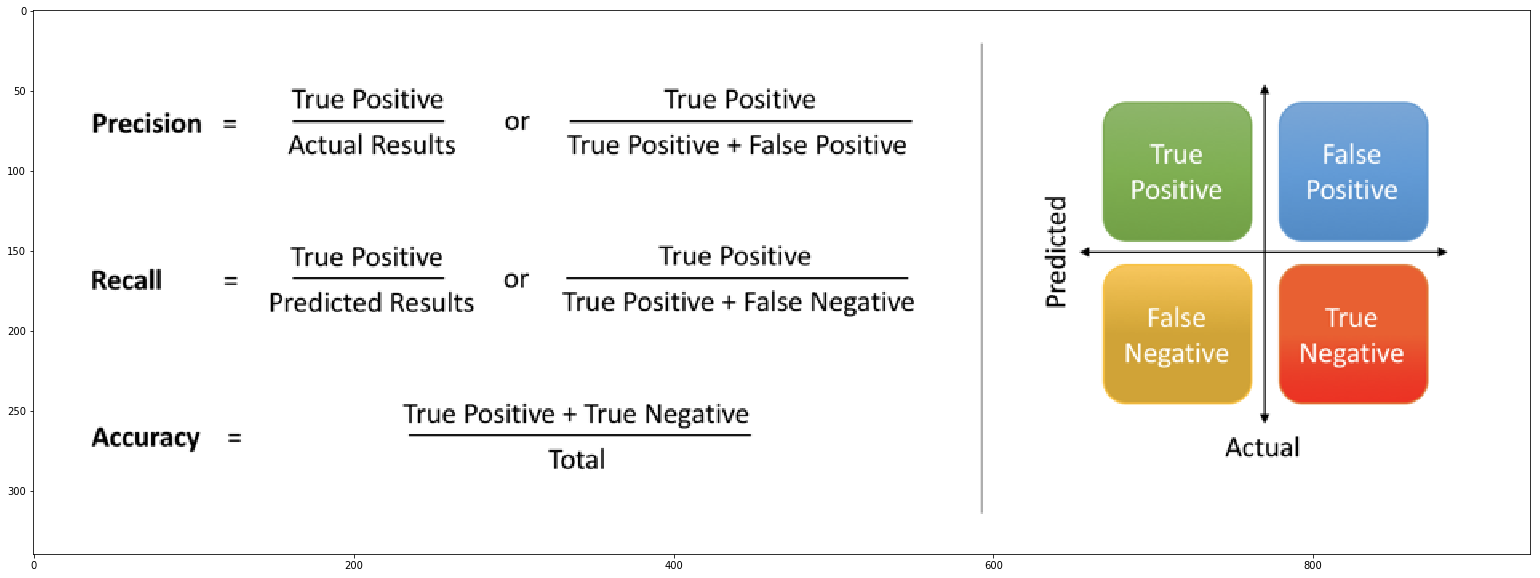

In [93]:
# Reminder
import matplotlib.image as mpimg

img=mpimg.imread('recall.png')
plt.figure(figsize=(50,10))
imgplot = plt.imshow(img)

In [94]:
# Calculation of accuracy
print ('accuracy_score: {}'.format(accuracy_score(y_test,y_pred )))
# Calculation of f1 score
print ('f1_score: {}'.format(f1_score(y_test, y_pred)))
# Calculation of recall_score
print ('recall_score: {}'.format(recall_score(y_test, y_pred)))
# Calculation of precision_score
print ('precision_score: {}'.format(precision_score(y_test, y_pred)))

accuracy_score: 0.986965831859231
f1_score: 0.0
recall_score: 0.0
precision_score: 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


These scores are very bad. We can see that our model predict 0 number of the pesrons supposed to be in the mail list (labeled 1). we can improve our model with different techniques as follow:

- Oversample minority class
- Tuning the model

In [95]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10601,     0],
       [  140,     0]])

In [96]:
print ('True Positive: {}'.format(cnf_matrix[1][1]))
print ('True Negative: {}'.format(cnf_matrix[0][0]))
print ('False Positive: {}'.format(cnf_matrix[0][1]))
print ('False Negative: {}'.format(cnf_matrix[1][0]))

True Positive: 0
True Negative: 10601
False Positive: 140
False Negative: 0


Here, in the confusion matrix we have diagonal values representing correct predictions (True Positive and True Negative), while non-diagonal elements are incorrect predictions (False Positive and False Negative). In the output, we have 10601 True negative and 140 False Positive (incorrect prediction of positive mail response).

That means instead of 99% accuracy we failed to reach our goal which is to **predict individuals to put in mail order for marketing campaign**

##### IV. Oversample minority class

To compensate imbalance in data we need to resample our data. For this data we use oversampling which can be defined as adding more copies of the minority class. Oversampling can be a good choice when we don’t have enough data to work with. In this project we will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

In [97]:
concat = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
no_resp = concat[concat.RESPONSE==0]
pos_resp = concat[concat.RESPONSE==1]

In [98]:
from sklearn.utils import resample
# Upsample minority
pos_resp_upsampled = resample(pos_resp,
                          replace=True, # sample with replacement
                          n_samples=len(no_resp), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_resp, pos_resp_upsampled])

In [99]:
# Check new class counts
upsampled.RESPONSE.value_counts()

1    31829
0    31829
Name: RESPONSE, dtype: int64

In [100]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.RESPONSE
X_train = upsampled.drop('RESPONSE', axis=1)

upsampled = ln.fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

# Checking accuracy
print ('accuracy_score: {}'.format(accuracy_score(y_test, upsampled_pred)))
# f1 score
print ('f1_score: {}'.format(f1_score(y_test, upsampled_pred)))
# recall_score
print ('recall_score: {}'.format(recall_score(y_test, upsampled_pred)))
# precision_score
print ('precision_score: {}'.format(precision_score(y_test, upsampled_pred)))

accuracy_score: 0.589051298761754
f1_score: 0.040851803563667966
recall_score: 0.6714285714285714
precision_score: 0.0210667861945316


In [101]:
# import the metrics class
cnf_matrix = metrics.confusion_matrix(y_test, upsampled_pred)
cnf_matrix

array([[6233, 4368],
       [  46,   94]])

In [66]:
print ('True Positive: {}'.format(cnf_matrix[1][1]))
print ('True Negative: {}'.format(cnf_matrix[0][0]))
print ('False Positive: {}'.format(cnf_matrix[0][1]))
print ('False Negative: {}'.format(cnf_matrix[1][0]))

True Positive: 94
True Negative: 6233
False Positive: 46
False Negative: 4368


##### V. Compare to our model

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.